In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from dynapsetorch.model import AdexLIF, AdexLIFfull

In [2]:
timestep = 0.1 * 1e-3
tau_soma = 5.0
tau_ampa = 20.0
tau_gaba_b = 5.0
tau_ahp = 2.0

simplified = AdexLIF(
    1, 1, dt=timestep, tau_soma=5, tau_ampa=20, tau_gaba_b=5.0, tau_ahp=2
)
simplified.soma_refP = 5 * 1e-3 / timestep
simplified.weight_ampa.data = torch.ones(1, 1) * 2
simplified.weight_gaba_b.data = torch.ones(1, 1) * 1

fullversion = AdexLIFfull(1)
fullversion.dt = timestep
fullversion.weight_nmda.data = torch.ones(1, 1) * 0
fullversion.weight_ampa.data = torch.ones(1, 1) * 2
fullversion.weight_gaba_a.data = torch.ones(1, 1) * 0
fullversion.weight_gaba_b.data = torch.ones(1, 1) * 1

## We don't want to add mismatch
fullversion.soma_refP.data = torch.tensor(5 * 1e-3)
fullversion.Inmda_w0 = torch.zeros_like(fullversion.Inmda_w0) + 100 * 1e-12
fullversion.Iampa_w0 = torch.zeros_like(fullversion.Iampa_w0) + 100 * 1e-12
fullversion.Igaba_a_w0 = torch.zeros_like(fullversion.Igaba_a_w0) + 100 * 1e-12
fullversion.Igaba_b_w0 = torch.zeros_like(fullversion.Igaba_b_w0) + 100 * 1e-12

In [3]:
Vs = []
IampaS = []
IgabaBS = []

Vf = []
IampaF = []
IgabaBF = []

input = (torch.rand(1000, 1, 1) < (100 * timestep)).float()

simplified.reset()
fullversion.state = fullversion.init_state(torch.rand(1, 1))
for t in range(input.shape[0]):
    simplified(input_ampa=input[t], input_gaba_b=input[t])
    fullversion(input_ampa=input[t], input_gaba_b=input[t])

    with torch.no_grad():
        Vs.append(simplified.state.Isoma_mem.data[0].clone().numpy())
        IampaS.append(simplified.state.Iampa.data[0].clone().numpy())
        IgabaBS.append(simplified.state.Igaba_b.data[0].clone().numpy())

        Vf.append(fullversion.state.Isoma_mem.data[0].clone().numpy() * 1e9)
        IampaF.append(fullversion.state.Iampa.data[0].clone().numpy() * 1e9)
        IgabaBF.append(fullversion.state.Igaba_b.data[0].clone().numpy() * 1e9)

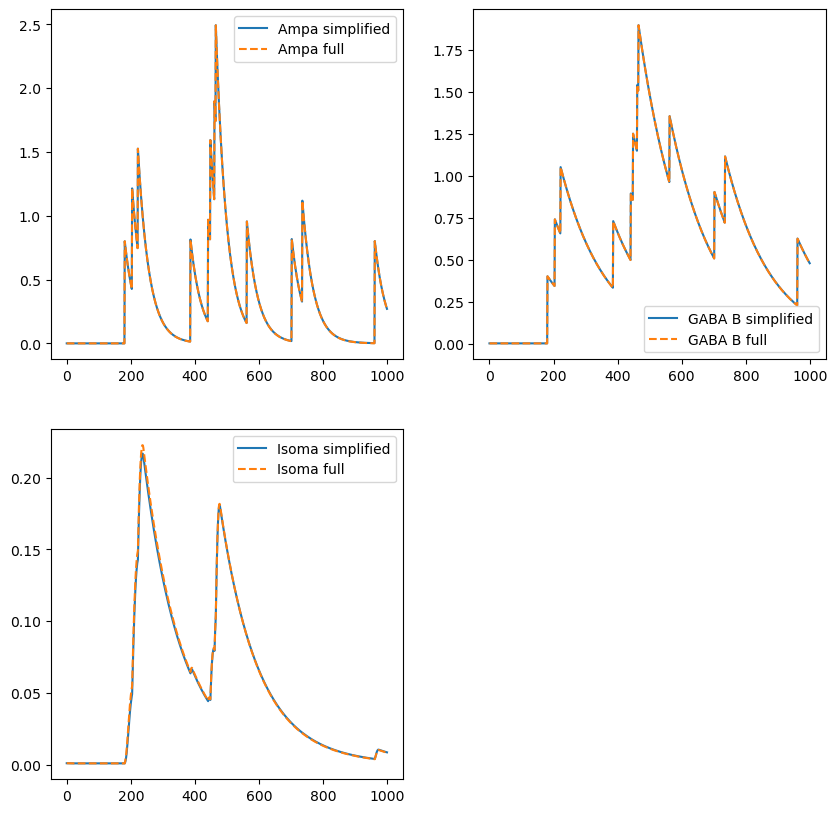

In [4]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(IampaS, label="Ampa simplified")
plt.plot(IampaF, "--", label="Ampa full")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(IgabaBS, label="GABA B simplified")
plt.plot(IgabaBF, "--", label="GABA B full")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(Vs, label="Isoma simplified")
plt.plot(Vf, "--", label="Isoma full")
plt.legend()